In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, sampler
import torch.optim as optim
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
'''
    explore the data
'''

try:
    os.mkdir("./data")
    print("Directory data Created")
except FileExistsError:
    print("Directory data already exists")
data_path = './data/'
train_dataset = torchvision.datasets.USPS(root=data_path, train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.USPS(root=data_path, train=False, download=True, transform=transforms.ToTensor())


Directory data already exists


In [ ]:
n_epochs = 3
batch_size_train = 100
batch_size_test = 200
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

torch.Size([200, 1, 16, 16])    torch.Size([200])
torch.Size([200, 16, 16])


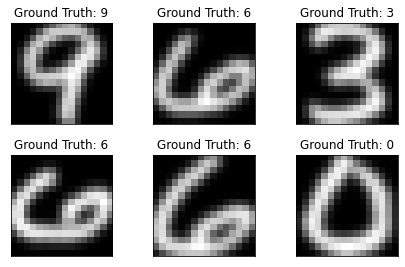

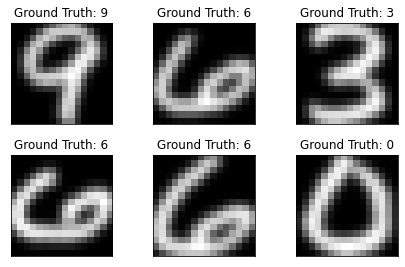

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, num_workers=4)

examples = enumerate(test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape,"  " ,example_targets.shape)

example_data = example_data.squeeze()
print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [ ]:
'''
    define SNN
'''

class PseudoSpikeRect(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, vth, grad_win, grad_amp):

        ctx.save_for_backward(input)
        ctx.vth = vth
        ctx.grad_win = grad_win
        ctx.grad_amp = grad_amp
        
        output = torch.gt(input, ctx.vth).float()
        
        return output

    @staticmethod
    def backward(ctx, grad_output):

        input, = ctx.saved_tensors
        vth = ctx.vth
        grad_win = ctx.grad_win
        grad_amp = ctx.grad_amp
        grad_input = grad_output.clone()
        
        spike_pseudo_grad = (abs(input - vth) < 0.5 * grad_win).float()

        grad = grad_amp * grad_input * spike_pseudo_grad.float()
        return grad, None, None, None

In [ ]:
class LinearIFCell(nn.Module):

    def __init__(self, psp_func, pseudo_grad_ops, param):
       
        super(LinearIFCell, self).__init__()
        self.psp_func = psp_func
        self.pseudo_grad_ops = pseudo_grad_ops
        self.vdecay, self.vth, self.grad_win, self.grad_amp = param

    def forward(self, input_data, state):
        pre_spike, pre_volt = state
        volt = pre_volt * self.vdecay * (1. - pre_spike) + self.psp_func(input_data)
        output = self.pseudo_grad_ops(volt, self.vth, self.grad_win, self.grad_amp)
        return output, (output, volt)

In [ ]:
class SingleHiddenLayerSNN(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim, param_dict):
        
        super(SingleHiddenLayerSNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        pseudo_grad_ops = PseudoSpikeRect.apply
        
        self.hidden_cell_1 = LinearIFCell(nn.Linear(self.input_dim, self.hidden_dim, bias=False), pseudo_grad_ops, param_dict['hid_layer'])
        self.hidden_cell_2 = LinearIFCell(nn.Linear(self.hidden_dim, self.hidden_dim, bias=False), pseudo_grad_ops, param_dict['hid_layer'])
        self.hidden_cell_3 = LinearIFCell(nn.Linear(self.hidden_dim, self.hidden_dim, bias=False), pseudo_grad_ops, param_dict['hid_layer'])
        self.output_cell = LinearIFCell(nn.Linear(self.hidden_dim, self.output_dim, bias=False), pseudo_grad_ops, param_dict['out_layer'])

    def forward(self, spike_data, init_states_dict, batch_size, spike_ts):
        
        hidden_state, out_state = init_states_dict['hid_layer'], init_states_dict['out_layer']
        hidden_state_01, hidden_state_02 = init_states_dict['hid_layer_01'], init_states_dict['hid_layer_02']
        spike_data_flatten = spike_data.view(batch_size, self.input_dim, spike_ts)
        output_list = []
        for tt in range(spike_ts):
            data_input = spike_data_flatten[:,:,tt]
            hidden_output, hidden_state = self.hidden_cell_1(data_input, hidden_state)
            # hidden_output, hidden_state_01 = self.hidden_cell_2(hidden_output, hidden_state_01)
            # hidden_output, hidden_state_02 = self.hidden_cell_3(hidden_output, hidden_state_02)
            out_output, out_state = self.output_cell(hidden_output, out_state)
            output_list.append(out_output)
        output = torch.sum(torch.stack(output_list), 0)
        return output

In [ ]:
class WrapSNN(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim, param_dict, device):
        
        super(WrapSNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.device = device
        self.snn = SingleHiddenLayerSNN(input_dim, output_dim, hidden_dim, param_dict)

    def forward(self, spike_data):
       
        batch_size = spike_data.shape[0]
        spike_ts = spike_data.shape[-1]
        init_states_dict = {}
        hidden_volt = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        hidden_spike = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        init_states_dict['hid_layer'] = (hidden_spike, hidden_volt)
        
        out_volt = torch.zeros(batch_size, self.output_dim, device=self.device)
        out_spike = torch.zeros(batch_size, self.output_dim, device=self.device)
        init_states_dict['out_layer'] = (out_spike, out_volt)

        hidden_volt_01 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        hidden_spike_01 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        init_states_dict['hid_layer_01'] = (hidden_spike_01, hidden_volt_01)

        hidden_volt_02 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        hidden_spike_02 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        init_states_dict['hid_layer_02'] = (hidden_spike_02, hidden_volt_02)



        output = self.snn(spike_data, init_states_dict, batch_size, spike_ts)
        return output

In [ ]:
def img_2_event_img(image, device, spike_ts):
    
    batch_size = image.shape[0]
    channel_size = image.shape[1]
    image_size = image.shape[2]
    image = image.view(batch_size, channel_size, image_size, image_size, 1)
    
    random_image = torch.rand(batch_size, channel_size, image_size, image_size, spike_ts, device=device)

    event_image = (random_image - image < 0).float()

    return event_image

In [ ]:
def stbp_snn_training(network, spike_ts, device, batch_size=128, test_batch_size=256, epoch=100):
    
    try:
        os.mkdir("./data")
        print("Directory data Created")
    except FileExistsError:
        print("Directory data already exists")
    
    data_path = './data/'
    train_dataset = torchvision.datasets.USPS(root=data_path, train=True, download=True, transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.USPS(root=data_path, train=False, download=True, transform=transforms.ToTensor())

  
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4)

    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(network.parameters(), lr = 0.1)

    train_loss_list, test_accuracy_list = [], []
    test_num = len(test_dataset)

    network.to(device)
    
    for ee in range(epoch):
        running_loss = 0.0
        running_batch_num = 0
        train_start = time.time()
        
        for data in train_dataloader:

            image, label = data[0], data[1]
            label = label.squeeze()
            image = image.to(device)
            label = label.to(device)
            
            event_image = img_2_event_img(image, device, spike_ts)
            event_image.squeeze()
            event_image = event_image.reshape(-1, 256, spike_ts)
            
            optimizer.zero_grad(set_to_none=False)
            network_output = network(event_image)
            loss = criterion(network_output, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_batch_num += 1
        train_end = time.time()
        train_loss_list.append(running_loss / running_batch_num)
        print("Epoch %d Training Loss %.4f" % (ee, train_loss_list[-1]), end=" ")
        
        
        test_correct_num = 0
        test_start = time.time()
        with torch.no_grad():
            for data in test_dataloader:
    
                image, label = data[0], data[1]
                label = label.squeeze()
                
                image = image.to(device)
                label = label.to(device)
                
                event_image = img_2_event_img(image, device, spike_ts)
                event_image.squeeze()
                event_image = event_image.reshape(-1, 256, spike_ts)
                
                outputs = network.forward(event_image)
                
                _, predicted = torch.max(outputs, 1)
                
                test_correct_num += (len(label) - torch.count_nonzero(label - predicted))
        
        test_end = time.time()
        test_accuracy_list.append(test_correct_num / test_num)
        print("Test Accuracy %.4f Training Time: %.1f Test Time: %.1f" % (test_accuracy_list[-1], train_end - train_start, test_end - test_start))
        # print(network.snn.hidden_cell_1.psp_func.weight.data)
        # print(network.snn.hidden_cell_2.psp_func.weight.data)
        # print(network.snn.hidden_cell_3.psp_func.weight.data)
    
    print("End Training")
    network.to('cpu')
    return train_loss_list, test_accuracy_list

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 256
output_dim = 10
hidden_dim = 128
param_dict = {
    'hid_layer':[0.3, 0.3, 0.5, 0.4],
    'out_layer':[0.3, 0.3, 0.5, 0.4]
}
snn_timestep = 20
network = WrapSNN(input_dim, output_dim, hidden_dim, param_dict, device)
batch_size_train = 100
batch_size_test = 200
epoch = 100
start_time = time.time()
train_loss_list, test_accuracy_list = stbp_snn_training(network, snn_timestep, device=device, batch_size=batch_size_train, test_batch_size=batch_size_test, epoch=epoch)
end_time = time.time()
print("Total time: ", end_time - start_time)

Directory data already exists


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 Training Loss 1.3112 Test Accuracy 0.8470 Training Time: 2.8 Test Time: 0.6
Epoch 1 Training Loss 0.3479 Test Accuracy 0.8884 Training Time: 2.8 Test Time: 0.6
Epoch 2 Training Loss 0.2770 Test Accuracy 0.8989 Training Time: 2.8 Test Time: 0.6
Epoch 3 Training Loss 0.2182 Test Accuracy 0.8954 Training Time: 2.9 Test Time: 0.6
Epoch 4 Training Loss 0.1906 Test Accuracy 0.9053 Training Time: 2.8 Test Time: 0.6
Epoch 5 Training Loss 0.1743 Test Accuracy 0.9133 Training Time: 3.5 Test Time: 0.6
Epoch 6 Training Loss 0.1561 Test Accuracy 0.9178 Training Time: 2.8 Test Time: 0.6
Epoch 7 Training Loss 0.1498 Test Accuracy 0.9098 Training Time: 2.9 Test Time: 0.6
Epoch 8 Training Loss 0.1358 Test Accuracy 0.9148 Training Time: 2.8 Test Time: 0.6
Epoch 9 Training Loss 0.1287 Test Accuracy 0.9153 Training Time: 3.2 Test Time: 0.6
Epoch 10 Training Loss 0.1125 Test Accuracy 0.9178 Training Time: 2.9 Test Time: 0.6
Epoch 11 Training Loss 0.1132 Test Accuracy 0.9188 Training Time: 2.9 Test 

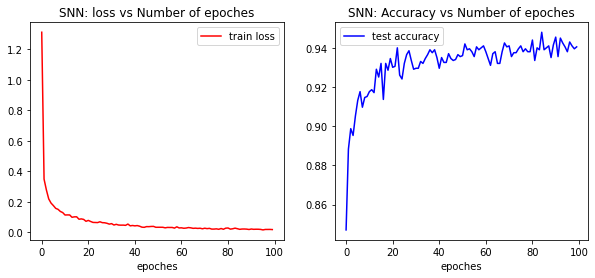

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x = [_ for _ in range(100)]

accuracy_snn = [_.to("cpu") for _ in test_accuracy_list]
loss_snn = train_loss_list

ax1.plot(x, loss_snn, label='train loss', color='red')
ax2.plot(x, accuracy_snn, label='test accuracy', color='blue')
ax1.set_title('SNN: loss vs Number of epoches')
ax2.set_title('SNN: Accuracy vs Number of epoches')
ax1.set_xlabel('epoches')
ax2.set_xlabel('epoches')
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
network.snn.hidden_cell.psp_func.weight.shape

torch.Size([128, 256])

In [ ]:
'''
    define ANN
'''

class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False) 
        self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu2 = nn.ReLU()
        # self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        # out = self.fc2(out)
        # out = self.relu2(out)
        # out = self.fc3(out)
        # out = self.relu3(out)
        out = self.fc4(out)
        return out


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def ann_train(network, device, train_batch_size=100, test_batch_size=200, epoch=100):
    
    try:
        os.mkdir("./data")
        print("Directory data Created")
    except FileExistsError:
        print("Directory data already exists")
    data_path = './data/'
    
    train_dataset = torchvision.datasets.USPS(root=data_path, train=True, download=True, transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.USPS(root=data_path, train=False, download=True, transform=transforms.ToTensor())

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr = 0.1)
    
    train_loss_list, test_accuracy_list = [], []
    test_num = len(test_dataset)
    
    network.to(device)

    # pca=PCA(n_components=256)
    
    for ee in range(epoch):
        running_loss = 0.0
        running_batch_num = 0
        train_start = time.time()
        
        for data in train_dataloader:
            image, label = data[0], data[1]
            label = label.squeeze()
            
            image = image.to(device)
            label = label.to(device)
            
            image = image.view(-1, 256)

            # image_ = pca.fit_transform(image)
            # img = torch.from_numpy(image_)
            
            optimizer.zero_grad(set_to_none=False)
            network_output = network(image)
            # network_output = network(img.float())
            loss = criterion(network_output, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_batch_num += 1

        train_end = time.time()
        train_loss_list.append(running_loss / running_batch_num)
        print("Epoch %d Training Loss %.4f" % (ee, train_loss_list[-1]), end=" ")
        
        test_correct_num = 0
        test_start = time.time()
        with torch.no_grad():
            for data in test_dataloader:
                
                image, label = data[0], data[1]
                label = label.squeeze()
                
                image = image.to(device)
                label = label.to(device)
                
                image = image.view(-1, 256)
                # image_ = pca.fit_transform(image)
                # img = torch.from_numpy(image_)
                outputs = network.forward(image)
                # outputs = network.forward(img.float())

                _, predicted = torch.max(outputs, 1)
                
                test_correct_num += (len(label) - torch.count_nonzero(label - predicted))
        
        test_end = time.time()
        test_accuracy_list.append(test_correct_num / test_num)
        print("Test Accuracy %.4f Training Time: %.1f Test Time: %.1f" % (
            test_accuracy_list[-1], train_end - train_start, test_end - test_start))
    
    print("End Training")
    network.to('cpu')
    return train_loss_list, test_accuracy_list

In [ ]:
input_dim = 256
hidden_dim = 128 

# input_dim = 256
# hidden_dim = 50

output_dim = 10

ann = ANNModel(input_dim, hidden_dim, output_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann_epoch = 100
train_batch_size, test_batch_size = 100, 200
start_time = time.time()
ann_loss, ann_accuracy = ann_train(ann, device=device, train_batch_size=train_batch_size, test_batch_size=test_batch_size, epoch=ann_epoch)
end_time = time.time()
print("Total time: ", end_time - start_time, "s")

Directory data already exists


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 Training Loss 1.5668 Test Accuracy 0.7773 Training Time: 0.9 Test Time: 0.3
Epoch 1 Training Loss 0.6315 Test Accuracy 0.8545 Training Time: 0.9 Test Time: 0.3
Epoch 2 Training Loss 0.3902 Test Accuracy 0.8789 Training Time: 0.9 Test Time: 0.3
Epoch 3 Training Loss 0.3101 Test Accuracy 0.8904 Training Time: 0.9 Test Time: 0.3
Epoch 4 Training Loss 0.2707 Test Accuracy 0.8999 Training Time: 0.9 Test Time: 0.3
Epoch 5 Training Loss 0.2465 Test Accuracy 0.9033 Training Time: 0.9 Test Time: 0.3
Epoch 6 Training Loss 0.2297 Test Accuracy 0.9048 Training Time: 0.9 Test Time: 0.3
Epoch 7 Training Loss 0.2171 Test Accuracy 0.9058 Training Time: 0.9 Test Time: 0.3
Epoch 8 Training Loss 0.2070 Test Accuracy 0.9088 Training Time: 0.9 Test Time: 0.3
Epoch 9 Training Loss 0.1987 Test Accuracy 0.9118 Training Time: 0.9 Test Time: 0.3
Epoch 10 Training Loss 0.1915 Test Accuracy 0.9138 Training Time: 0.9 Test Time: 0.3
Epoch 11 Training Loss 0.1853 Test Accuracy 0.9163 Training Time: 0.9 Test 

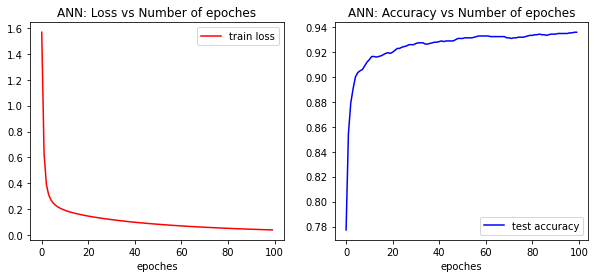

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x = [_ for _ in range(ann_epoch)]

accuracy_ann = [_.to("cpu") for _ in ann_accuracy]

ax1.plot(x, ann_loss, label='train loss', color='red')
ax2.plot(x, accuracy_ann, label='test accuracy', color='blue')
ax1.set_title('ANN: Loss vs Number of epoches')
ax2.set_title('ANN: Accuracy vs Number of epoches')
ax1.set_xlabel('epoches')
ax2.set_xlabel('epoches')
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
'''
    define the test function to test the updated weight for SNN
'''

def test_SNN(network, spike_ts, device, test_batch_size=256, epoch=100):

    try:
        os.mkdir("./data")
    except FileExistsError:
        a = 0
    
    data_path = './data/'
    
    test_dataset = torchvision.datasets.USPS(root=data_path, train=False, download=True, transform=transforms.ToTensor())
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4)
    
    test_accuracy_list = []
    test_num = len(test_dataset)
    network.to(device)         
    
    test_correct_num = 0
    test_start = time.time()
    with torch.no_grad():
        for data in test_dataloader:
            image, label = data[0], data[1]
            label = label.squeeze()

            image = image.to(device)
            label = label.to(device)

            event_image = img_2_event_img(image, device, spike_ts)
            event_image.squeeze()
            event_image = event_image.reshape(-1, 256, spike_ts)

            outputs = network.forward(event_image)

            _, predicted = torch.max(outputs, 1)

            test_correct_num += (len(label) - torch.count_nonzero(label - predicted))

    test_end = time.time()
    test_accuracy_list.append(test_correct_num / test_num)
    print("Test Accuracy %.4f  Test Time: %.1f" % (
        test_accuracy_list[-1], test_end - test_start))
    return test_accuracy_list[-1]

In [ ]:
'''
    update the weight of SNN with the train result of ANN
'''

scalers = [ _/100 for _ in range(5, 200, 5)]
ann_2_snn_accuracy_list = []
for scaler in scalers:
    print("scaler = ", scaler)
    network.snn.hidden_cell_1.psp_func.weight.data = scaler * ann.fc1.weight.data
    network.snn.output_cell.psp_func.weight.data = scaler * ann.fc4.weight.data
    accuracy = test_SNN(network, 20, device = device, test_batch_size=256, epoch=100)
    ann_2_snn_accuracy_list.append(accuracy)

scaler =  0.05


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy 0.1789  Test Time: 0.7
scaler =  0.1
Test Accuracy 0.6263  Test Time: 0.6
scaler =  0.15
Test Accuracy 0.8889  Test Time: 0.6
scaler =  0.2
Test Accuracy 0.8904  Test Time: 0.6
scaler =  0.25
Test Accuracy 0.8675  Test Time: 0.6
scaler =  0.3
Test Accuracy 0.8450  Test Time: 0.6
scaler =  0.35
Test Accuracy 0.8371  Test Time: 0.6
scaler =  0.4
Test Accuracy 0.8072  Test Time: 0.6
scaler =  0.45
Test Accuracy 0.7952  Test Time: 0.6
scaler =  0.5
Test Accuracy 0.7843  Test Time: 0.6
scaler =  0.55
Test Accuracy 0.7638  Test Time: 0.6
scaler =  0.6
Test Accuracy 0.7509  Test Time: 0.6
scaler =  0.65
Test Accuracy 0.7285  Test Time: 0.6
scaler =  0.7
Test Accuracy 0.7250  Test Time: 0.6
scaler =  0.75
Test Accuracy 0.7165  Test Time: 0.6
scaler =  0.8
Test Accuracy 0.7120  Test Time: 0.6
scaler =  0.85
Test Accuracy 0.6921  Test Time: 0.6
scaler =  0.9
Test Accuracy 0.6861  Test Time: 0.6
scaler =  0.95
Test Accuracy 0.6826  Test Time: 0.6
scaler =  1.0
Test Accuracy 0.6761  

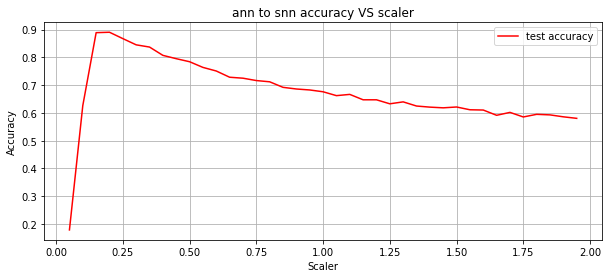

In [ ]:
ann_to_snn_accuracy = [_.to("cpu") for _ in ann_2_snn_accuracy_list]
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(scalers, ann_to_snn_accuracy, label='test accuracy', color='red')
ax.set_title('ann to snn accuracy VS scaler')
ax.set_xlabel('Scaler')
ax.set_ylabel('Accuracy')
ax.legend()
plt.grid()
plt.show()